In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as U
from torchvision.datasets import MNIST

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import numpy as np

def image_transform(img):
    return T.ToTensor()(img).squeeze(dim=0).flatten()
    
train_ds = MNIST(root=".", download=True, train=True, transform=image_transform)
test_ds = MNIST(root=".", download=True, train=False, transform=image_transform)


train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
sample_imgs, sample_labels = next(iter(train_dataloader))
sample_imgs.shape

torch.Size([64, 784])

In [51]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 100),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(100, 400),
            nn.ReLU(),
            nn.Linear(400, 784)
        )

    def forward(self, x, verbose=False):
        encoded = self.encoder(x.flatten(start_dim=1))
        if verbose:
            print("Encoded: \n", encoded)
        decoded = self.decoder(encoded)
        return decoded

In [52]:
testNet = AE()
testNet(sample_imgs).shape

torch.Size([64, 784])

In [53]:

def train(model, dataloader, loss_func, optimizer_func, verbose=True):
    model.train()
    loss_arr = []

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_func(pred, X)
        optimizer_func.zero_grad()
        loss.backward()
        optimizer_func.step()

        loss_arr.append(loss.item())
        
        if(verbose):
            if(batch%100 == 0):
                print(f'batch: {batch} loss: {loss.item()} [{batch*len(X)} / {len(dataloader.dataset)}]')
    return loss_arr

In [54]:
@torch.no_grad()
def test(model, dataloader):
    loss_fn = nn.MSELoss()
    total_loss = 0
    total_samples = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, X)
        total_loss += loss.item()
    return [total_loss, total_samples]


In [55]:

def test_learning_rates(Network, dataloader, learning_rates):
    losses = []
    for lr in learning_rates:
        loss_func = nn.MSELoss()
        main_net = Network().to(device)
        optimizer_func = torch.optim.SGD(main_net.parameters(), lr=lr)
        
        loss_arr = train(main_net, dataloader, loss_func, optimizer_func, verbose=False)

        losses.append(loss_arr)
    return losses

In [56]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.9]
total_losses = test_learning_rates(AE, train_dataloader, learning_rates)

rows,cols, idx = 2, 3, 0
subs = make_subplots(rows=rows, cols=cols, subplot_titles=learning_rates)

for row in range(rows):
    for col in range(cols):
        if(row == 1 and col == 2): break;
        subs.add_trace(go.Scatter(y=total_losses[idx]), row=row+1, col=col+1)
        idx+=1

subs.show()

In [57]:

def test_epochs(Network, dataloader, number_of_epochs, learning_rate=0.9):
    epoch_list = []
    accuracy_list = []
    main_net = Network().to(device)
    loss_func = nn.MSELoss()
    optimizer_func = torch.optim.SGD(main_net.parameters(), lr=learning_rate)

    for i in range(number_of_epochs):
        epoch_list.append(i)
        train(main_net, dataloader, loss_func, optimizer_func, verbose=False)
        correct, total = test(main_net, dataloader)
        accuracy_list.append(correct/total)
    return accuracy_list

In [ ]:
epochs_result = test_epochs(AE, train_dataloader, 15)

In [ ]:
px.line([x*100 for x in epochs_result])

In [ ]:
epochs = 15
myNet = AE()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(myNet.parameters(), lr=0.9)

for epoch in range(epochs):
    print("Epoch: ", epoch+1)
    train(myNet, train_dataloader, loss_fn, optimizer)

Epoch:  1
batch: 0 loss: 0.11366978287696838 [0 / 60000]
batch: 100 loss: 0.06596887111663818 [6400 / 60000]
batch: 200 loss: 0.06700939685106277 [12800 / 60000]
batch: 300 loss: 0.06069748103618622 [19200 / 60000]
batch: 400 loss: 0.05800459906458855 [25600 / 60000]
batch: 500 loss: 0.052122391760349274 [32000 / 60000]
batch: 600 loss: 0.05078096315264702 [38400 / 60000]
batch: 700 loss: 0.04840140417218208 [44800 / 60000]
batch: 800 loss: 0.04462316632270813 [51200 / 60000]
batch: 900 loss: 0.04149773716926575 [57600 / 60000]
Epoch:  2
batch: 0 loss: 0.041128505021333694 [0 / 60000]
batch: 100 loss: 0.037685852497816086 [6400 / 60000]
batch: 200 loss: 0.03826112300157547 [12800 / 60000]
batch: 300 loss: 0.03475193679332733 [19200 / 60000]
batch: 400 loss: 0.03556700423359871 [25600 / 60000]
batch: 500 loss: 0.0351722277700901 [32000 / 60000]
batch: 600 loss: 0.03375804051756859 [38400 / 60000]
batch: 700 loss: 0.03002917766571045 [44800 / 60000]
batch: 800 loss: 0.03085782378911972 [

In [ ]:
[loss, count] = test(myNet, test_dataloader)
print("Accuracy: ", loss/count)

Accuracy:  0.00016895329048857092


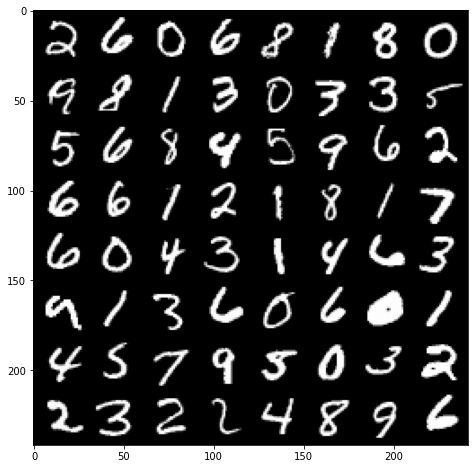

In [ ]:
from matplotlib import axes
# plt.imshow(sample_imgs[1].reshape(28, 28), cmap="gray")
grid = U.make_grid(sample_imgs.reshape(64, 1, 28, 28))
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))

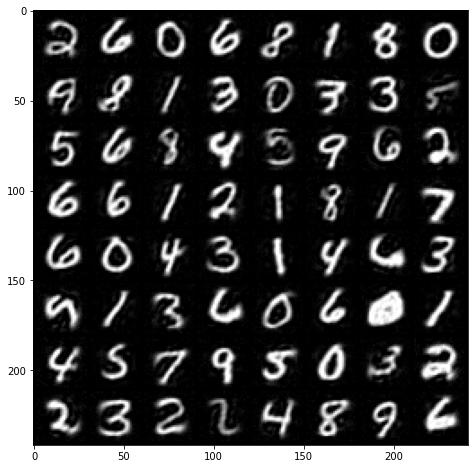

In [ ]:
output = myNet(sample_imgs)
plt.figure(figsize=(8,8))
grid = U.make_grid(output.reshape(64, 1, 28, 28)).permute(1, 2, 0)
plt.imshow(grid.detach().numpy())
# plt.imshow(output[1].reshape(28, 28).detach().numpy(), cmap="gray")
